In [1]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data, 
    seq_data, 
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from pyeit import mesh

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2025-02-06 12:59:13.477906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738846753.491767  955881 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738846753.495956  955881 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 12:59:13.512006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1738846764.101726  955881 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [44]:
def transform_position(position):

    center_offset = position[0]
    position_centered = position - center_offset
    tank_radius = 97        #should be improved with tank = Tank...Properties()
    position_scaled_centered = position_centered / tank_radius
    
    return position_scaled_centered[1:]

def create_anomaly(mesh_obj, x, y, r):

    anomaly = [PyEITAnomaly_Circle(center=[x, y], r=r, perm=0.9)]
    ms = mesh.set_perm(mesh_obj, anomaly=anomaly, background=0.1)
    
    return ms
    
def create_gamma(positions):
   
    n_el = 32
    mesh_obj = mesh.create(n_el, h0=0.05)
    gamma_list = []
    
    for pos in positions:
        x, y = pos
        ms = create_anomaly(mesh_obj, x, y, 0.2)
        gamma_list.append(ms.perm_array)
    
    return np.array(gamma_list)  

def load_2Ddata(file_path, file_name ,use_mean= True):
    
    print("Loading experimental data...")
    voltage, _, _, position = load_exp_data(file_path, file_name)

    print("Calculating absolute voltages...")
    voltage_abs = np.abs(voltage) #absolutwert berechnen
    
    print("Normalizing data...")
    voltage_normalized = (voltage_abs - np.mean(voltage_abs)) / np.std(voltage_abs)

    print("Subtracting voltage measurements from empty tank...")
    voltage_diff = voltage_normalized - voltage_normalized[0] #substraktion von ersten messung (leere Tankmessung)
    voltage_diff = voltage_diff[1:]  # erste Messung "wegwerfen"

    #use mean oder alle Messungen (burst counts) einzeln
    if use_mean:
        print("Calculating mean of voltage differences...")
        voltage_diff = np.mean(voltage_diff, axis=1)
    
    # Transformiere Positionsdaten 
    print("Transforming position data...")
    trans_pos = transform_position(position)
    print(trans_pos.shape)
 
    # Erstelle Gamma
    print("Creating gamma...")
    gamma = create_gamma(trans_pos)
    print(gamma.shape)
    gamma = gamma.reshape(-1, 2840, 1)
    voltage_diff = voltage_diff.reshape(-1, 32, 32, 1)
    
    if use_mean:
        print("Processing sequences with mean...")
        voltage_seq, gamma_seq = seq_data(voltage_diff, gamma, n_seg=4)
    else:
        print("Processing sequences for each measurement...")
        voltage_sequences = []
        gamma_sequences = []
        
        for idx in tqdm(range(5), desc="Processing measurement sequences"):
            v_seq, g_seq = seq_data(voltage_diff[:, idx, :, :], gamma, n_seg=4)
            voltage_sequences.append(v_seq)
            gamma_sequences.append(g_seq)
            
        print("Concatenating sequences...")
        voltage_seq = np.concatenate(voltage_sequences, axis=0)
        gamma_seq = np.concatenate(gamma_sequences, axis=0)
    
    print("Data loading complete!")
    return voltage_seq, gamma_seq


## Aufrufen der Load Data Function basierend auf den Daten, die man fürs Training nutzen möchte ##

In [45]:
voltage, gamma = load_2Ddata("exp_data_set", "exp_data44") #1.Trainingsdaten

Loading experimental data...
Calculating absolute voltages...
Normalizing data...
Subtracting voltage measurements from empty tank...
Calculating mean of voltage differences...
Transforming position data...
(12000, 2)
Creating gamma...
(12000, 2840)
Processing sequences with mean...
Data loading complete!


In [46]:
print(gamma.shape)

(11996, 2840, 1)


In [29]:
gamma = gamma.reshape(-1, 2840, 1)

## Loading VAE Model and generating labels

In [47]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [48]:
_, _, latent_rep = vae.encoder.predict(gamma)

375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


In [49]:
latent_rep.shape

(11996, 8)

In [50]:
gamma.shape

(11996, 2840, 1)

In [51]:
voltage.shape

(11996, 4, 32, 32, 1)

## LSTM Mapper Training

In [52]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage,
    gamma,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [53]:
from src.lstm_mapper_model import mapper_model
lstm_mapper = mapper_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=100, batch_size = 8, validation_split = 0.1)

Epoch 1/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.2847 - val_loss: 0.3604
Epoch 2/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.2844 - val_loss: 0.2481
Epoch 3/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.2327 - val_loss: 0.2108
Epoch 4/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2104 - val_loss: 0.2069
Epoch 5/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.2077 - val_loss: 0.2016
Epoch 6/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1995 - val_loss: 0.1961
Epoch 7/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1879 - val_loss: 0.1901
Epoch 8/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1880 - val_loss: 0.1859
Epoch 9/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1912 - val_loss: 0.1840
Epoch 10/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1828 - val_loss: 0.1852
Epoch 11/30
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1849 - val_loss: 0.1802
Epoch 12/30
1215/1215 ━━━━━━━

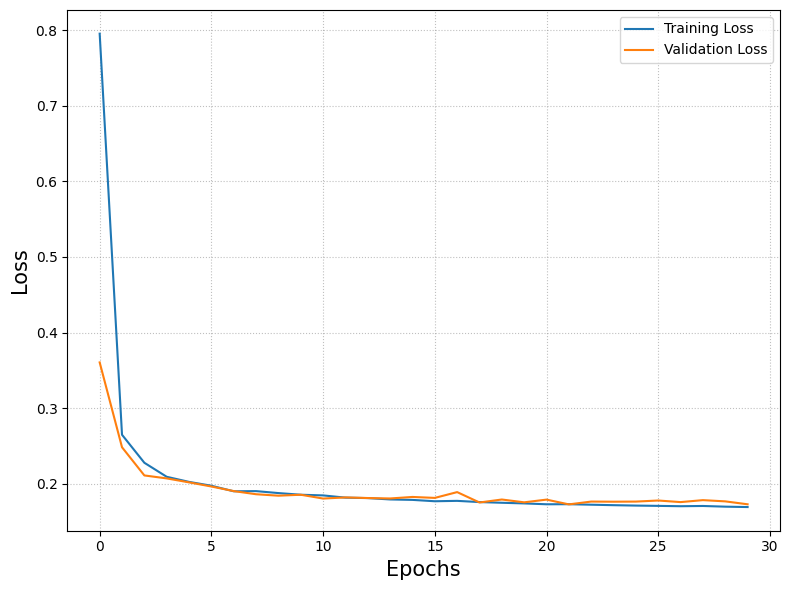

In [60]:
fpath = 'Abbildungen/'  
fname = 'loss_curve_LSTM_12000_Spiral'

plt.figure(figsize=(8, 6))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle=':', color='gray', alpha=0.5)

plt.savefig(f'{fpath}{fname}.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [61]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_12000_Spiral.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_12000_Spiral.weights.h5


In [6]:
lstm_mapper.load_weights("weights/lstm_12000_Spiral.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


/home/jy2353/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Load Test-Data

In [7]:
folder_paths = ["exp_data42"]
voltage_test_seq, gamma_true_test = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)

In [8]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [9]:
from src.performance_eval_2D import (compute_evaluation_metrics,
    plot_random_deviations, 
    plot_random_recon_examples, 
    plot_deviations_x_y,
    plot_deviations_perm,
    merge_plots_to_pdf,
    run_deviation_analysis)
    

Plot saved to: Abbildungen/random_deviations_circle_interpol_sim_02_08.pdf


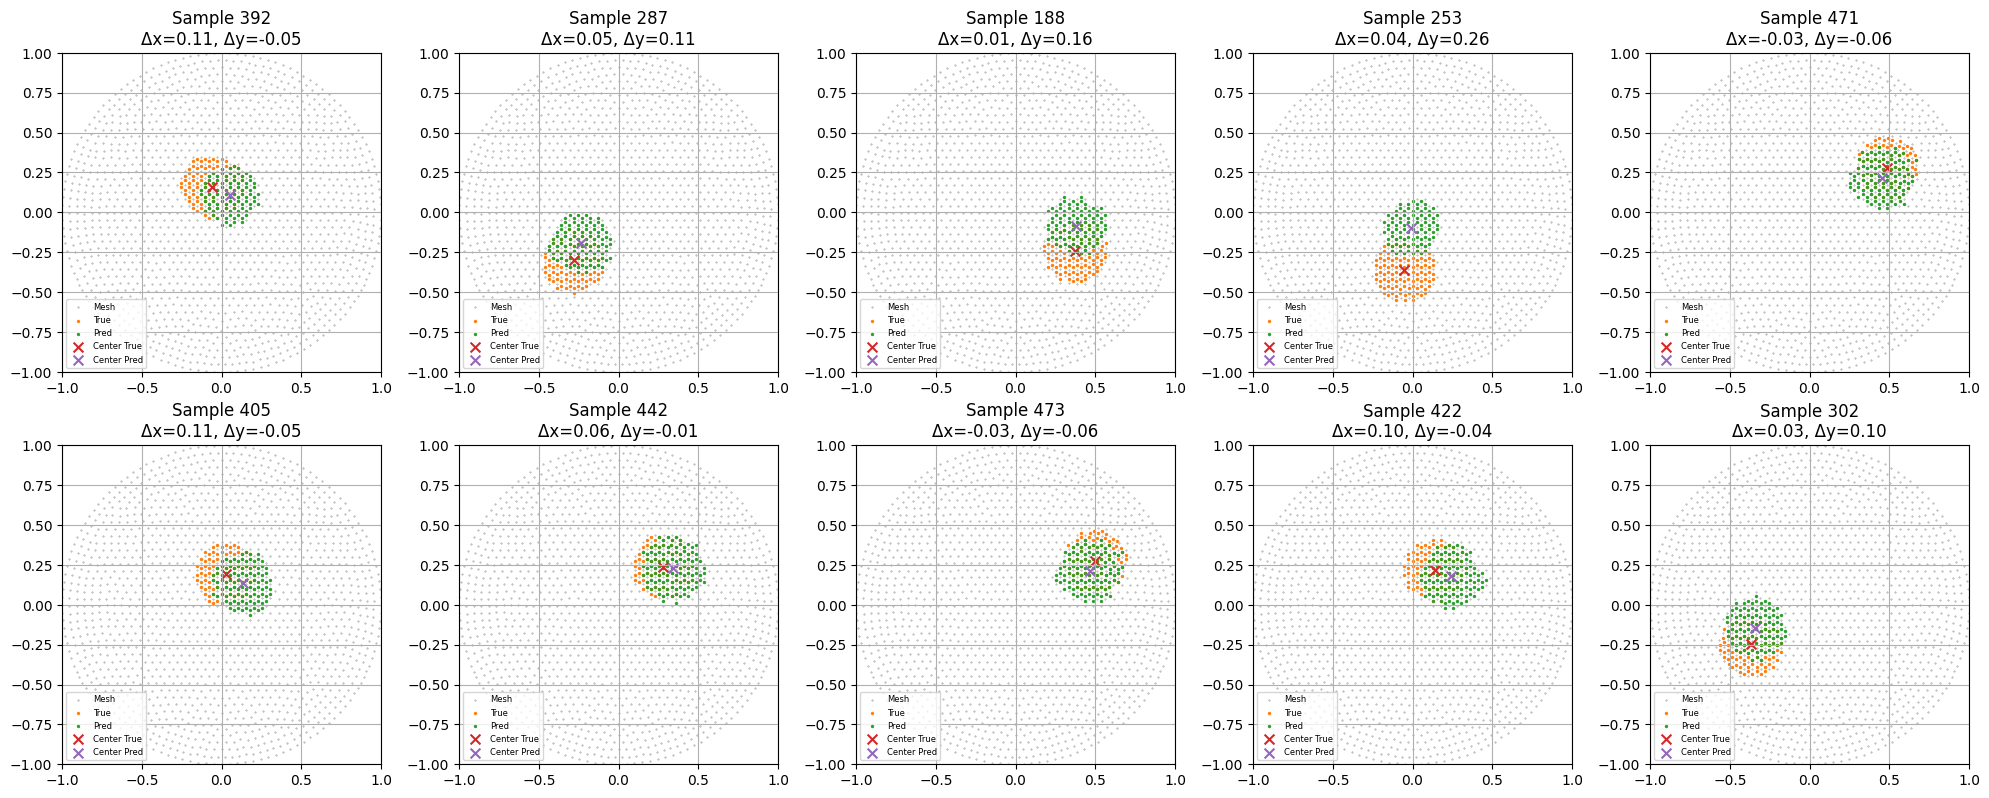

In [10]:
plot_random_deviations(mesh_obj, gamma_true_test, gamma_pred_test, num_samples=10, threshold=0.5, save=True, fpath='Abbildungen/',
                      fname='random_deviations_circle_interpol_sim_02_08.pdf')

Plots saved as:
PNG: Abbildungen/random_reconstructions_circle_interpol_sim_02_08.png
PDF: Abbildungen/random_reconstructions_circle_interpol_sim_02_08.pdf


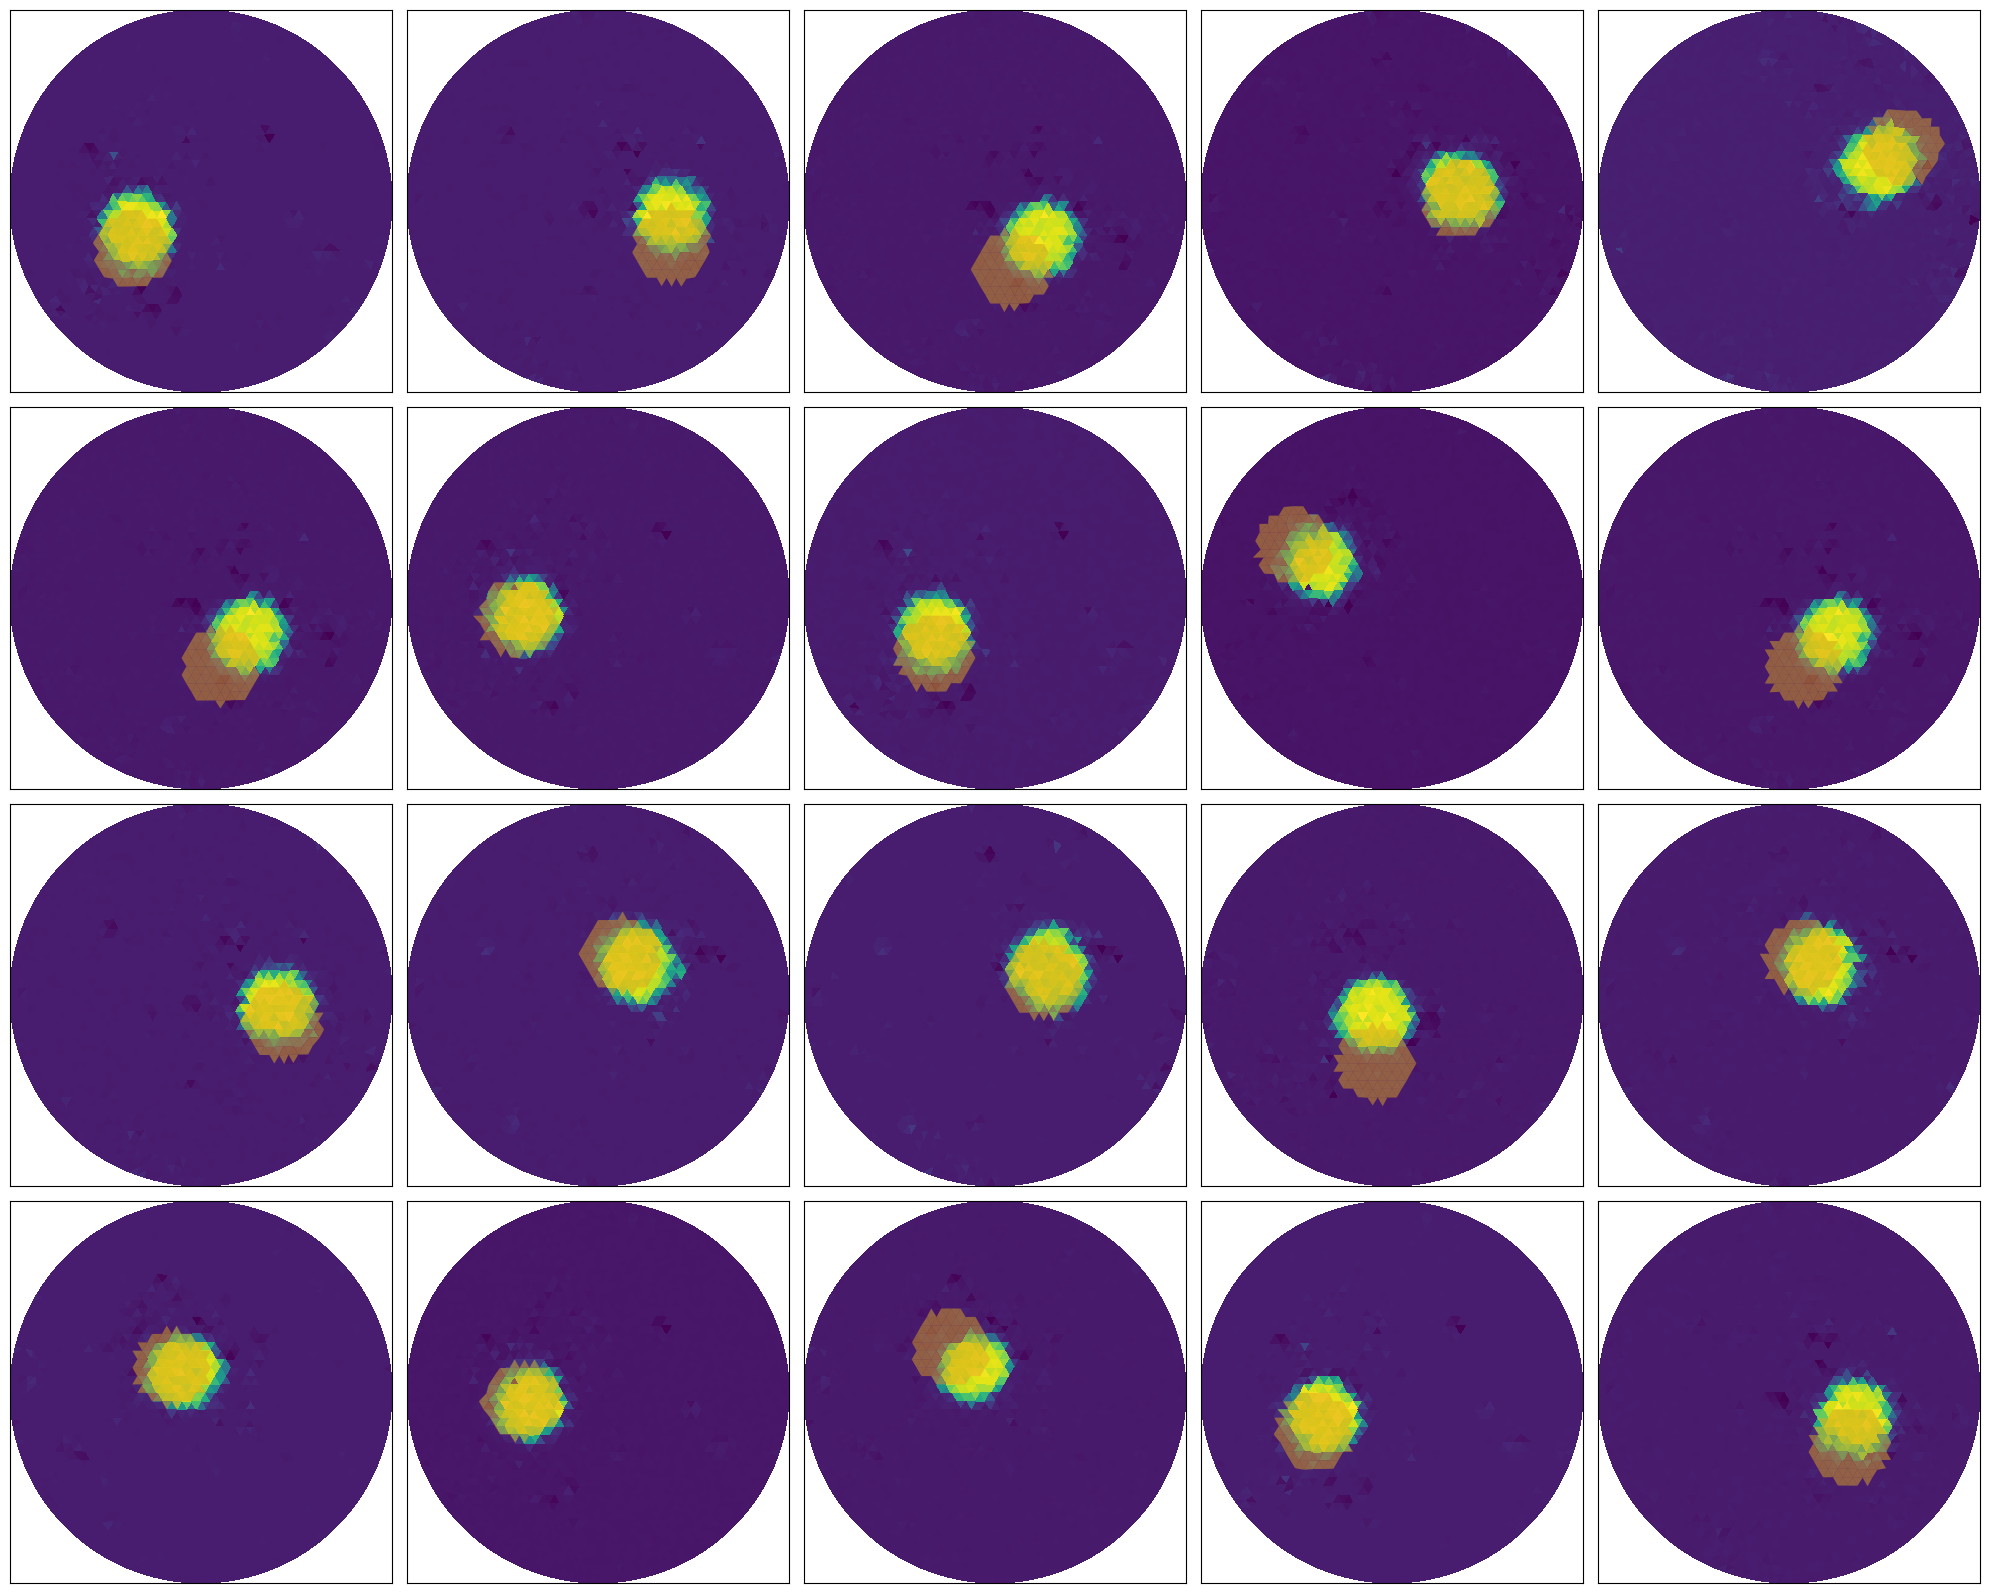

In [11]:
fig = plot_random_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, 
                               num_samples=20,
                               save=True, 
                               fpath='Abbildungen/',
                               fname='random_reconstructions_circle_interpol_sim_02_08.pdf')

In [22]:
def plot_sequence_recon_examples(mesh_obj, true_perm, pred_perm, num_plots=20,
                               save=False, fpath='', fname=''):
    """
    Plot reconstruction examples in sequence with automatically adjusted step size.
    
    Parameters:
    -----------
    mesh_obj : mesh object
        The mesh object containing node and element information
    true_perm : array
        True permittivity values
    pred_perm : array
        Predicted permittivity values
    num_plots : int
        Number of plots to generate (default: 20)
    save : bool
        Whether to save the plots
    fpath : str
        File path for saving
    fname : str
        File name for saving
    """
    # Calculate total available indices
    total_samples = len(true_perm)
    
    # Calculate step size to cover the whole range with num_plots
    # We use max(1, ...) to ensure step_size is at least 1
    step_size = max(1, (total_samples - 1) // (num_plots - 1))
    
    # Calculate indices to plot
    # Using linspace to ensure we get exactly num_plots points including start and end
    indices = np.linspace(0, total_samples - 1, num_plots).astype(int)
    
    # Calculate rows and columns for subplot grid
    cols = 5
    rows = (num_plots + cols - 1) // cols  # Ceiling division
    
    fig = plt.figure(figsize=(4*cols, 4*rows))
    
    pts = mesh_obj.node
    tri = mesh_obj.element
    x, y = pts[:, 0], pts[:, 1]
    
    # Calculate triangle centers for plotting true values
    tri_centers = np.mean(pts[tri], axis=1)
    
    for i, idx in enumerate(indices):
        true_values = true_perm[idx].flatten()
        pred_values = pred_perm[idx].flatten()
    
        ax = plt.subplot(rows, cols, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        im_ped = ax.tripcolor(x, y, tri, pred_values, shading="flat", 
                            edgecolor='none', linewidth=0.001, alpha=1.0, 
                            cmap='viridis')
        
        # Plot true values
        threshold = 0.5
        mask = true_values > threshold
        if np.any(mask):
            for j in np.where(mask)[0]:
                triangle = tri[j]
                triangle_pts = pts[triangle]
                ax.fill(triangle_pts[:, 0], triangle_pts[:, 1], 
                       color='goldenrod', alpha=0.5,
                       edgecolor='w', linewidth=0.001)
        
        # Set limits to exactly match the frame
        ax.set_ylim([-1, 1])
        ax.set_xlim([-1, 1])
        # Force the aspect ratio to be exactly square and fill the frame
        ax.set_aspect('equal', adjustable='box', anchor='C')
        
        # Add index number as title
        #ax.set_title(f'Index: {idx}')
    
    plt.tight_layout()
    
    if save:
        # Create full paths for both PNG and PDF
        base_path = os.path.splitext(fpath + fname)[0]  # Remove any existing extension
        png_path = base_path + '.png'
        pdf_path = base_path + '.pdf'
        
        try:
            # Save as PNG first
            plt.savefig(png_path, bbox_inches='tight', dpi=300)
            
            # Convert PNG to PDF
            image = Image.open(png_path)
            # Convert to RGB if necessary (in case the image is RGBA)
            if image.mode in ('RGBA', 'LA'):
                background = Image.new('RGB', image.size, (255, 255, 255))
                background.paste(image, mask=image.split()[-1])
                image = background
            
            image.save(pdf_path, 'PDF', resolution=300.0)
            
            print(f"Plots saved as:\nPNG: {png_path}\nPDF: {pdf_path}")
            
            os.remove(png_path)
            
        except Exception as e:
            print(f"Error saving files: {str(e)}")
    
    plt.show()

Error saving files: name 'Image' is not defined


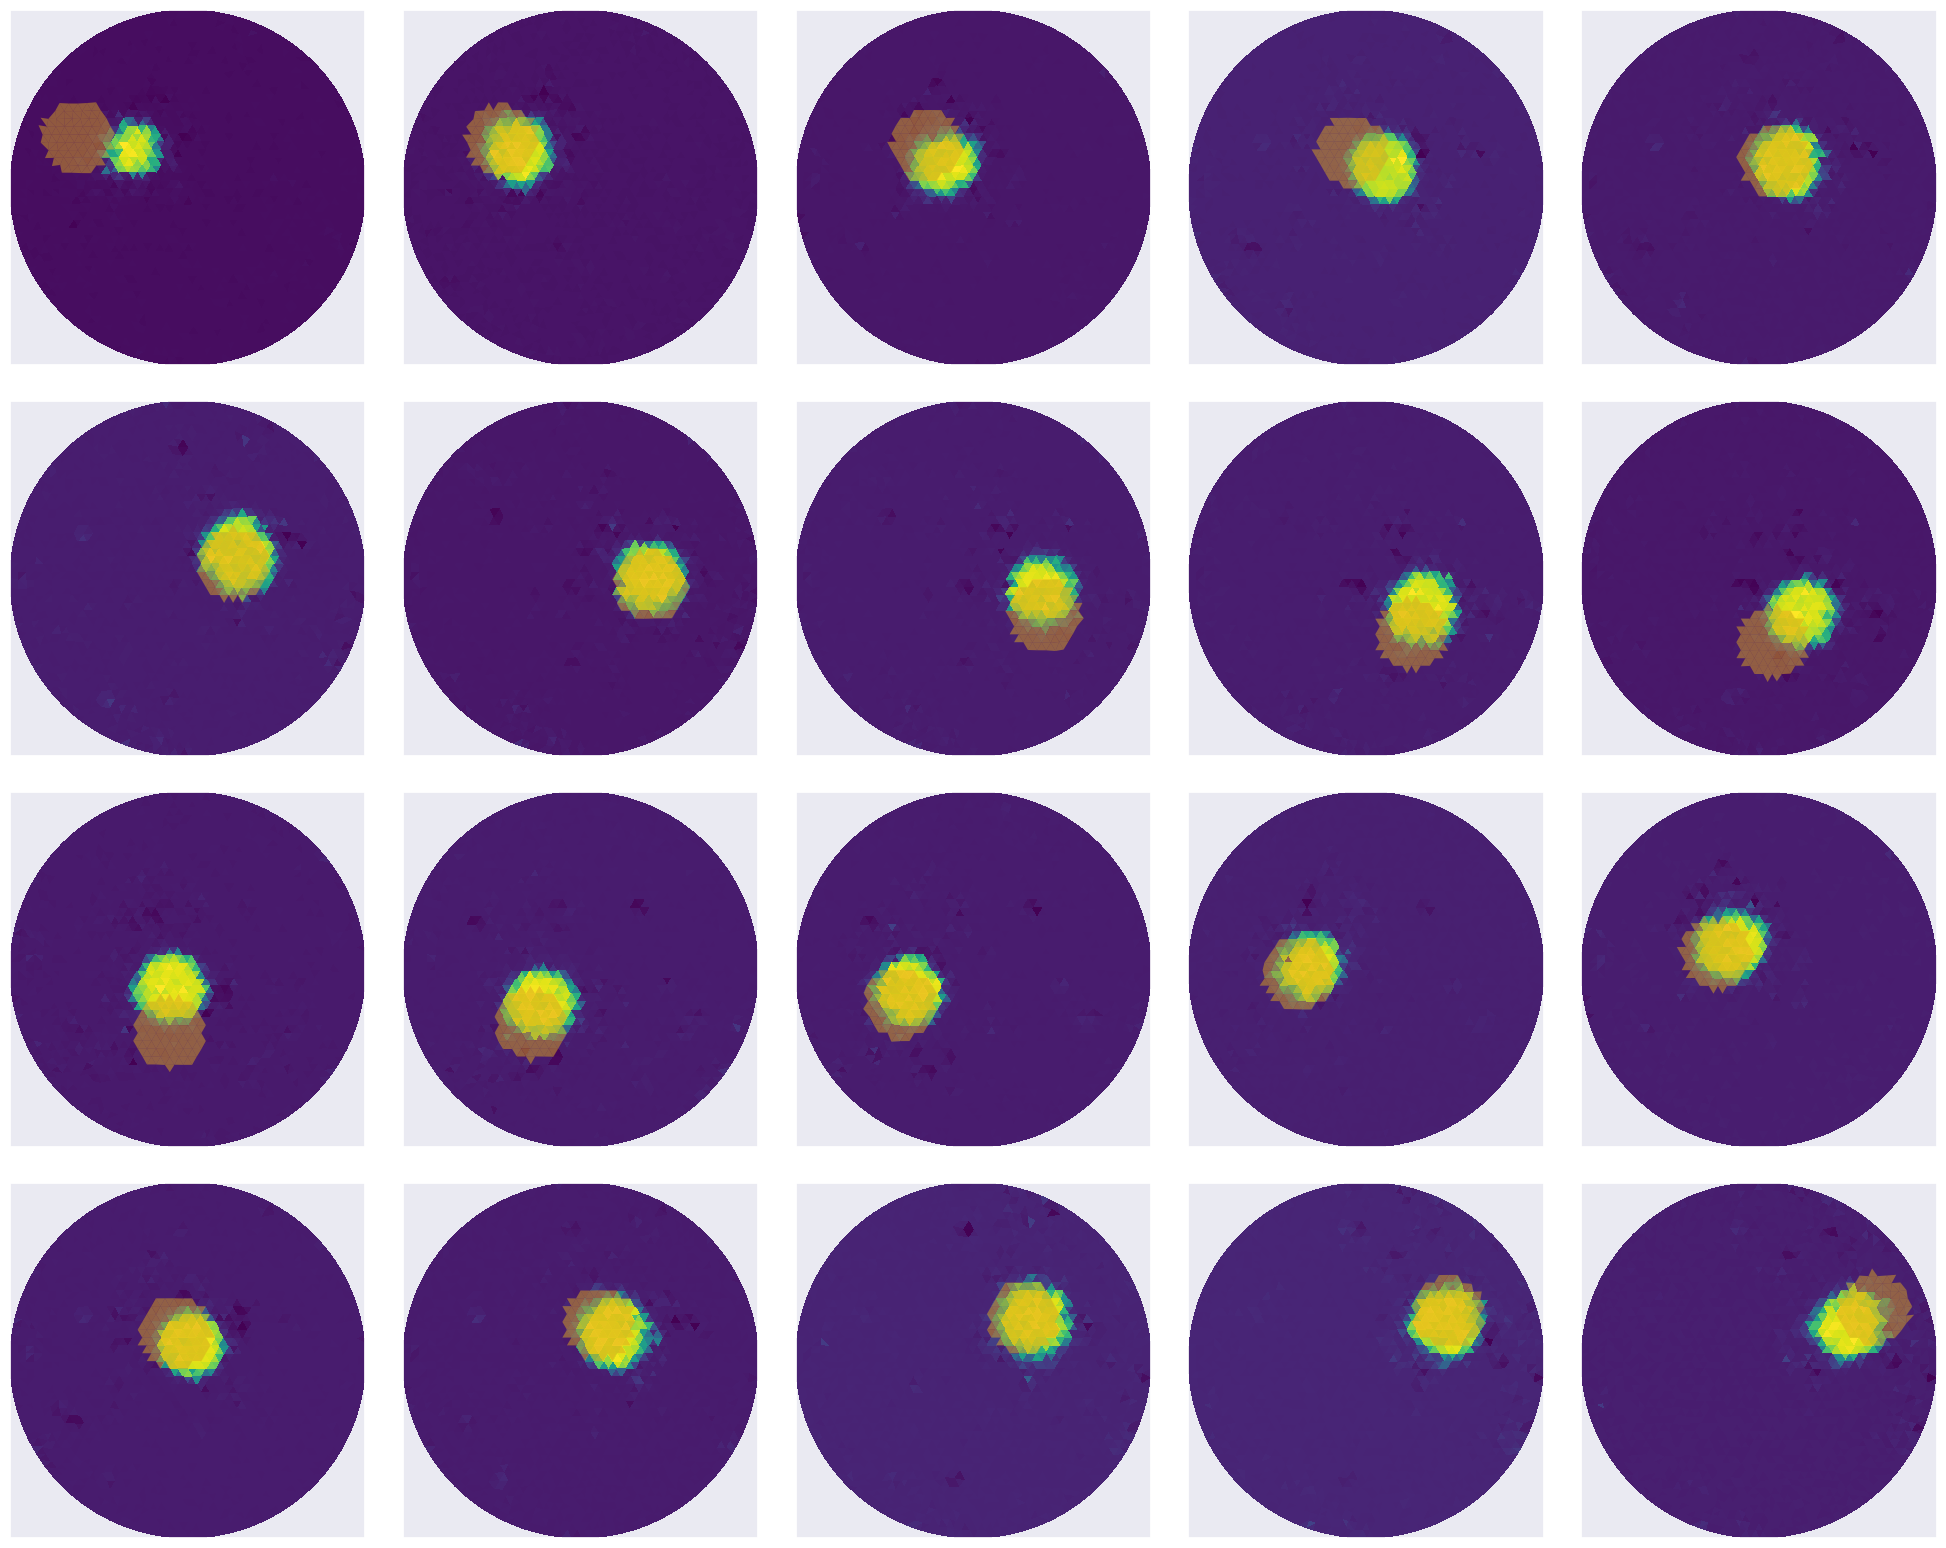

In [23]:
fig = plot_sequence_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, 
                                 num_plots=20,
                                 save=True, 
                                 fpath='Abbildungen/',
                                 fname='seq_reconstructions_circle_interpol_sim_02_08.pdf')

Statistics saved to: Abbildungen/position_circle_interpol_sim_02_08_deviations.pdf_stats.txt
Plot saved to: Abbildungen/position_circle_interpol_sim_02_08_deviations.pdf
Statistics saved to: Abbildungen/perm_circle_interpol_sim_02_08_deviations.pdf_stats.txt
Merged analysis plots saved as: Abbildungen/combined_circle_interpol_sim_02_08_deviations.pdf
Analysis complete. Final merged PDF saved as: Abbildungen/combined_circle_interpol_sim_02_08_deviations.pdf


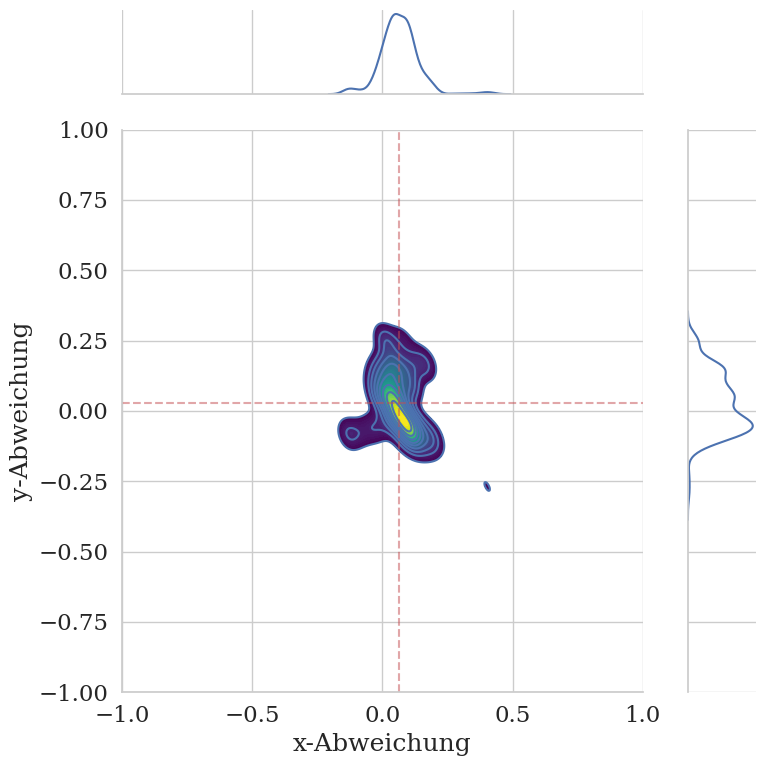

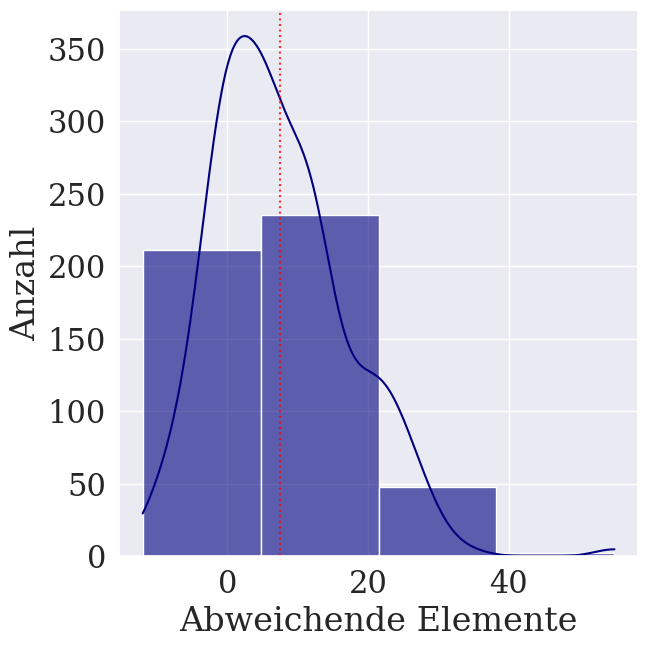

In [15]:
fpath = 'Abbildungen/'
base_fname = 'circle_interpol_sim_02_08'

run_deviation_analysis(gamma_true_test, gamma_pred_test, mesh_obj, fpath, base_fname)